In [1]:
from math import fabs
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression

In [2]:
SAMPLES = 10000 # This is not enough data for such high dimensionality - the model is going to be biased
DIVERGENCE_VALUE = 10
MAX_ITERATIONS = 10 ** 5
STOP_THRESHOLD = 10 ** -10
DIMENSIONS = 7
LAMBDA = 0.01
MU = 0.0001
ALPHA = 0.5
BETA = 0.99

In [3]:
np.random.seed(0)

In [4]:
(X, y, coef) = make_regression(n_samples = SAMPLES, 
                               n_features = DIMENSIONS - 1, 
                               n_informative = DIMENSIONS - 1, 
                               effective_rank = 2,
                               n_targets = 1, 
                               coef = True,
                               bias = 3,
                               tail_strength = 0)

In [5]:
coef

array([75.78410261, 21.72818777, 75.92203362, 56.5729803 , 77.78913092,
       18.43607803])

$\displaystyle \min_{\beta}\frac{1}{n}||y-X\beta||^2_{2}+\lambda||\beta||_1 + \mu||\beta||_2^2$

$L=\frac{1}{n}\displaystyle\sum_{i=1}^{n}\left(y_i - \left(\beta_0 + \displaystyle\sum_{j=1}^{6} \beta_j x_{ij}\right)\right)^2 + \lambda\displaystyle\sum_{j=0}^{6}|\beta_j| + \mu\displaystyle\sum_{j=0}^{6} \beta_j^2$

$\frac{\partial L}{\partial \beta_0} = -\frac{2}{n}\displaystyle\sum_{i=1}^{n}\left(y_i - \beta_0 -\displaystyle\sum_{j=1}^{6} \beta_j x_{ij}\right) + \lambda\frac{\beta_0}{|\beta_0|} + 2\mu\beta_0$

And for $\beta_{k\neq 0}$:

$\frac{\partial L}{\partial \beta_{k}} = -\frac{2}{n}\displaystyle\sum_{i=1}^{n}x_{ik}\left(y_i - \beta_0 -\displaystyle\sum_{j=1}^{6} \beta_j x_{ij}\right) + \lambda\frac{\beta_k}{|\beta_k|} + 2\mu\beta_k$

In [6]:
np.random.seed(0)

In [7]:
(X, y, coef) = make_regression(n_samples = SAMPLES, 
                               n_features = DIMENSIONS - 1, 
                               n_informative = DIMENSIONS - 1, 
                               effective_rank = 2,
                               n_targets = 1, 
                               coef = True,
                               bias = 3,
                               tail_strength = 0)

In [8]:
X = np.hstack((np.ones((SAMPLES, 1)), X))

In [9]:
# Auxiliary function to calculate gradient
# l = lambda
# m = mu
def calculate_gradient(x, y, l, m, current_params):
    db = np.zeros(DIMENSIONS)    
    
    # Common term
    common = (y - 
              current_params[0] - 
              np.sum(np.multiply(np.tile(current_params[1:], (SAMPLES, 1)), x[:, 1:]), axis=1))
    
    # Function for the regularisation factor
    def regularisation(param, l, m):
        return l * param / fabs(param) + 2 * m * param
    
    # db_0
    db[0] = - 2 / float(SAMPLES) * np.sum(common) + regularisation(current_params[0], l, m)

    # db_k, k != 0
    for k in range(1, DIMENSIONS):
        db[k] = -2 / float(SAMPLES) * np.sum(np.multiply(x[:, k], common)) + regularisation(current_params[k], l, m)
    return db

In [10]:
def _loss(params, l, m):
        y_pred = np.matmul(X, np.array(params))
        L = np.mean(np.power(y - y_pred, 2), axis = 0)
        L = L + l * np.sum(np.fabs(params)) + m * np.sum(np.power(params, 2))
        return L

In [11]:
# Auxiliary function for backtracking line search
# Not using exact because I would have to do second partial derivatives with respect to t
# However, the line backtracking algorithm is very sensitive to alpha, so maybe use the direct
# approach for the line algorithm if we can calculate it
# Besides, baktracking line search is very slow
def line_search(current_params, gradient, beta, l, m):
    current_params = np.array(current_params)
        
    t = 1.0
    while _loss(current_params - t * gradient, l, m) > _loss(current_params, l, m) - \
                                                         t * ALPHA * np.matmul(gradient.T, gradient):
        t = t * beta
        
    return t

In [12]:
# Coordinate gradient descent implementation
# Cycling through the dimensions
def cdg(X, y, current_params, l, m):
    w = [np.array(current_params[:])]
    it = 0
    while it == 0 or (np.sum(np.abs(np.array(current_params) - np.array(w[-1]))) > STOP_THRESHOLD and \
                      np.all(np.array(current_params) - np.array(w[-1]) < DIVERGENCE_VALUE) and \
                      it < MAX_ITERATIONS):
        w.append(current_params)
        # Select the gradient for the next dimension
        d = it % DIMENSIONS
        g = np.zeros(DIMENSIONS)
        g[d] = calculate_gradient(X, y, l, m, current_params)[d]
        # Linear search in the direction of the selected dimension
        t = line_search(current_params, g, BETA, l, m)
        # Update parameters
        current_params = list(np.array(w[-1]) - t * np.array(g))[:]
        # Wrapping up the iteration
        it = it + 1
    w.append(current_params)
    
    return(it, current_params, w)

Using 0.1 as the initial values for the parameters to prevent divisions by zero during gradient calculation

In [13]:
it, current_params, w = cdg(X, y, [0.1 for i in range(DIMENSIONS)], LAMBDA, MU)

In [14]:
it

168

In [15]:
_loss([3] + list(coef), 0, 0)

9.417889872690914e-32

In [16]:
_loss(current_params, 0, 0)

0.9682244188548642

In [17]:
_loss([0.1 for i in range(DIMENSIONS)], 0, 0)

9.29099479672584

(array([1.000e+00, 4.000e+00, 9.000e+00, 1.800e+01, 6.500e+01, 1.580e+02,
        3.430e+02, 6.590e+02, 9.910e+02, 1.350e+03, 1.577e+03, 1.543e+03,
        1.199e+03, 9.090e+02, 6.210e+02, 3.410e+02, 1.210e+02, 5.900e+01,
        2.500e+01, 7.000e+00]),
 array([-4.21962916, -3.83340564, -3.44718211, -3.06095858, -2.67473505,
        -2.28851153, -1.902288  , -1.51606447, -1.12984094, -0.74361742,
        -0.35739389,  0.02882964,  0.41505317,  0.80127669,  1.18750022,
         1.57372375,  1.95994728,  2.3461708 ,  2.73239433,  3.11861786,
         3.50484139]),
 <a list of 20 Patch objects>)

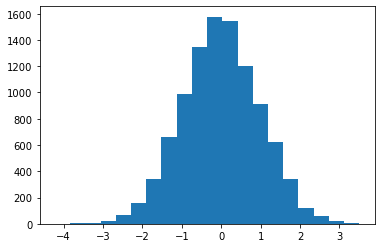

In [18]:
plt.hist(np.matmul(X, np.array(current_params)) - np.matmul(X, np.array([3] + list(coef))), bins = 20)

In [19]:
[3] + list(coef)

[3,
 75.78410261068944,
 21.728187771684905,
 75.92203361699748,
 56.572980297077535,
 77.789130921549,
 18.436078025540404]

In [20]:
current_params

[2.9793652143610063,
 0.1463822426076789,
 -3.7577641436975597e-10,
 5.43965285393991e-11,
 0.1900441673603966,
 9.112273627112912e-05,
 -2.658605311679812e-11]